# 🔭 OneClassSVM - Train ASTRO + Test UNIDs

In [1107]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ML tools
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [1108]:
# Load dataset
data_path = "../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

# Preview the data
df_astro.head()

,E_peak,beta,sigma,beta_Rel,"0,1=astro,DM"
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [1109]:
df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
print(df_astro.columns)

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


In [1110]:
df_astro.describe()

,E_peak,beta,sigma,beta_Rel,class
count,2831.000000,2831.000000,2831.000000,2831.000000,2831.0
mean,-0.086668,-0.935025,1.112434,-0.219436,0.0
std,1.280269,0.425847,0.370543,0.447146,0.0
min,-5.912006,-2.602060,0.609189,-3.198657,0.0
25%,-0.683526,-1.190440,0.819636,-0.431508,0.0
50%,0.008004,-0.935917,1.037837,-0.185014,0.0
75%,0.689384,-0.643496,1.328710,0.026877,0.0
max,5.918502,0.000000,2.899104,1.629309,0.0


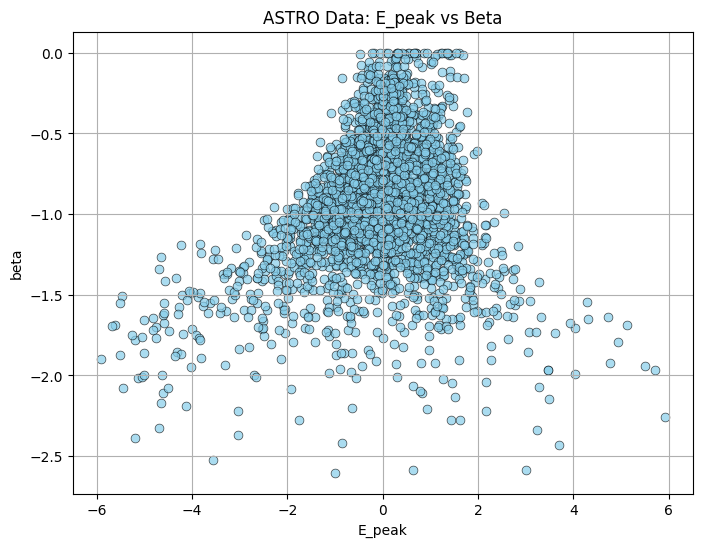

In [1111]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_astro,
    x="E_peak",
    y="beta",
    color="skyblue",  # or "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()


## Split data into Training and Testing (Within ASTRO) - Check distribution of both sets

In [1112]:
from sklearn.model_selection import train_test_split

X = df_astro[["beta", "E_peak"]].values
y = df_astro["class"].values

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

Check training and testing data:

In [1113]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1981, 2)
X_test shape: (850, 2)


In [1114]:
# Convert to DataFrame for better readability
pd.DataFrame(X_train, columns=["E_peak", "beta"]).head()

,E_peak,beta
0,-0.630042,-0.346807
1,-0.894831,-0.480750
2,-0.321118,-0.029960
3,-0.473919,-0.444156
4,-0.849244,-0.411235


In [1115]:
pd.DataFrame(X_test, columns=["E_peak", "beta"]).head()

,E_peak,beta
0,-0.656198,0.836172
1,-0.960586,0.292411
2,-0.841035,-1.483399
3,-0.716925,-0.747560
4,-1.128427,0.383869


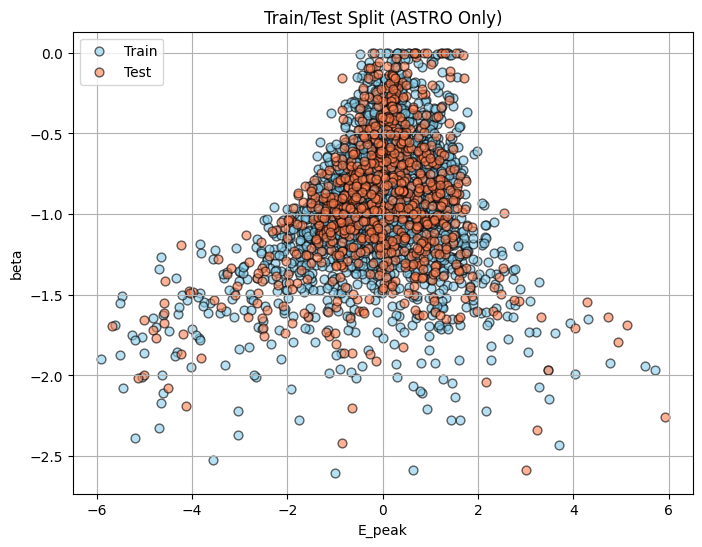

In [1116]:
plt.figure(figsize=(8, 6))

plt.scatter(X_train[:, 1], X_train[:, 0], label='Train', color='skyblue', edgecolors='k', alpha=0.6, s=40)
plt.scatter(X_test[:, 1], X_test[:, 0], label='Test', color='coral', edgecolors='k', alpha=0.6, s=40)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Train/Test Split (ASTRO Only)")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# 🏋🏽‍♀️ OneClassSVM Model - Training

In [1117]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model
clf = OneClassSVM(kernel='rbf', nu=0.004, gamma='scale')

# Train the model
clf.fit(X_train_scaled)


OneClassSVM(nu=0.004)

Visualize "learned" frontier of the trained model

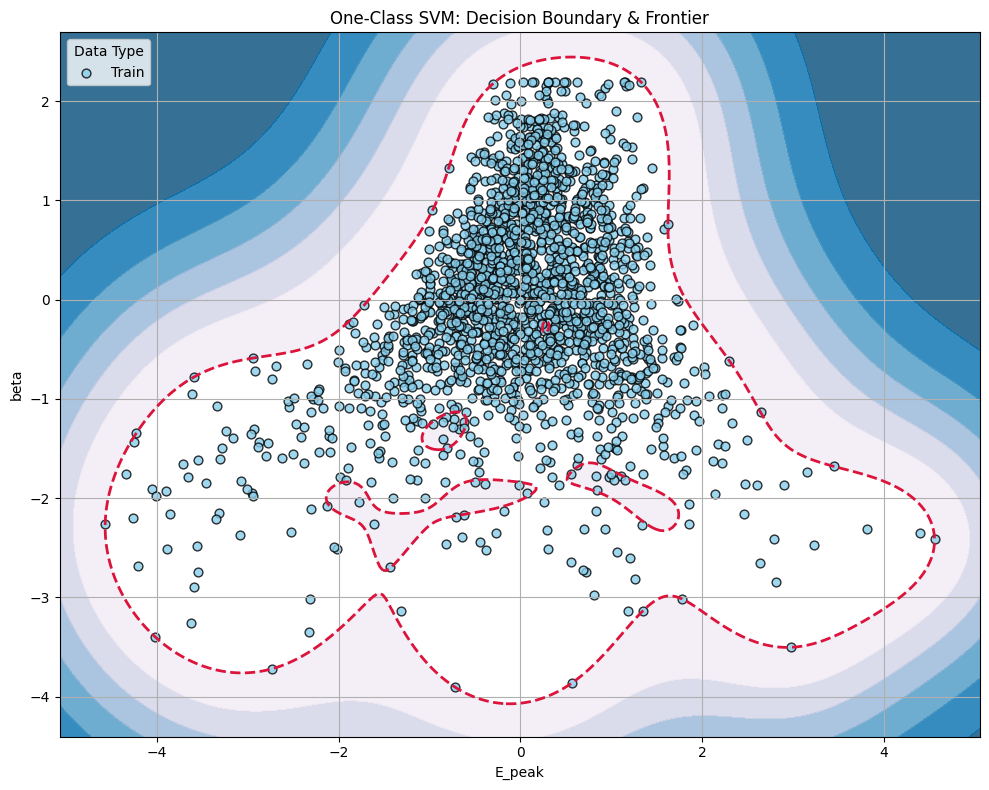

In [1118]:
import numpy as np
import matplotlib.pyplot as plt

# Meshgrid for decision function visualization
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

grid = np.c_[yy.ravel(), xx.ravel()]  # Match feature order: beta (0), E_peak (1)
Z = clf.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

# Background decision score (negative values)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)

# Learned frontier
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training data
plt.scatter(
    X_train_scaled[:, 1],
    X_train_scaled[:, 0],
    c='skyblue',
    edgecolors='k',
    s=40,
    label="Train",
    alpha=0.8
)

# Plot test data
"""plt.scatter(
    X_test_scaled[:, 1],
    X_test_scaled[:, 0],
    c='mediumorchid',
    edgecolors='k',
    s=40,
    label="Test",
    alpha=0.8
)"""

# Axis labels and styling
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM: Decision Boundary & Frontier")
plt.legend(title="Data Type", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Model - Predictions on ASTRO Test Set

In [1119]:
# make predictions
# +1 = inlier, -1 = outlier
y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)


In [1120]:
# Evaluate results of trained model
n_error_train = (y_pred_train == -1).sum()
n_error_test = (y_pred_test == -1).sum()

pct_error_train = 100 * n_error_train / len(X_train)
pct_error_test = 100 * n_error_test / len(X_test)

print(f"Training errors (outliers): {n_error_train}/{len(X_train_scaled)}")
print(f"Testing errors (outliers): {n_error_test}/{len(X_test_scaled)}")

Training errors (outliers): 40/1981
Testing errors (outliers): 11/850


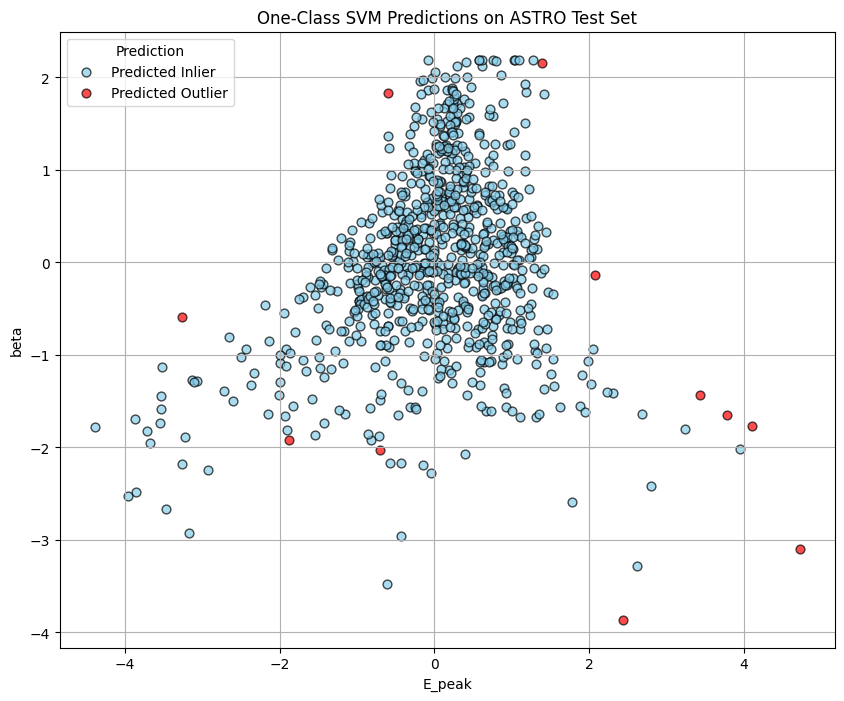

In [1121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Predicted inliers
plt.scatter(
    X_test_scaled[y_pred_test == 1, 1],
    X_test_scaled[y_pred_test == 1, 0],
    c="skyblue",
    edgecolors='k',
    label="Predicted Inlier",
    alpha=0.7,
    s=40
)

# Predicted outliers
plt.scatter(
    X_test_scaled[y_pred_test == -1, 1],
    X_test_scaled[y_pred_test == -1, 0],
    c="red",
    edgecolors='k',
    label="Predicted Outlier",
    alpha=0.7,
    s=40
)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM Predictions on ASTRO Test Set")
plt.legend(title="Prediction", loc='upper left')
plt.grid(True)
plt.show()


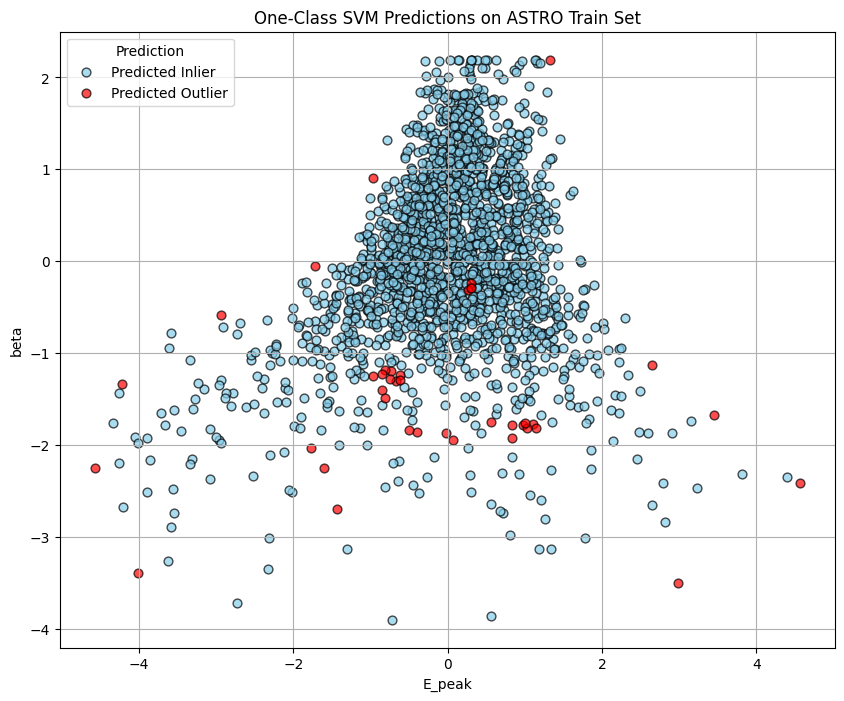

In [1122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Predicted inliers
plt.scatter(
    X_train_scaled[y_pred_train == 1, 1],
    X_train_scaled[y_pred_train == 1, 0],
    c="skyblue",
    edgecolors='k',
    label="Predicted Inlier",
    alpha=0.7,
    s=40
)

# Predicted outliers
plt.scatter(
    X_train_scaled[y_pred_train == -1, 1],
    X_train_scaled[y_pred_train == -1, 0],
    c="red",
    edgecolors='k',
    label="Predicted Outlier",
    alpha=0.7,
    s=40
)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM Predictions on ASTRO Train Set")
plt.legend(title="Prediction", loc='upper left')
plt.grid(True)
plt.show()


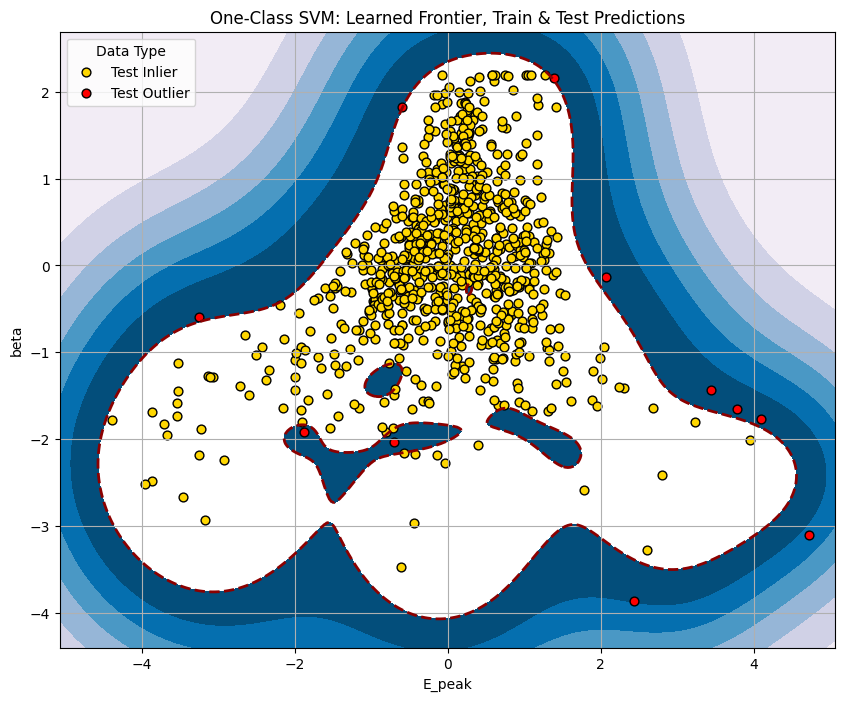

In [1123]:
# Create meshgrid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

grid = np.c_[yy.ravel(), xx.ravel()]  # beta first, then E_peak
Z = clf.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

# Decision function background and frontier
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred', linestyles='--')  # Learned frontier

"""# Training data
plt.scatter(
    X_train_scaled[:, 1],
    X_train_scaled[:, 0],
    c='skyblue',
    edgecolors='k',
    s=40,
    label='Train'
)"""

# Test data: predicted inliers
plt.scatter(
    X_test_scaled[y_pred_test == 1, 1],
    X_test_scaled[y_pred_test == 1, 0],
    c='gold',
    edgecolors='k',
    s=40,
    label='Test Inlier'
)

# Test data: predicted outliers
plt.scatter(
    X_test_scaled[y_pred_test == -1, 1],
    X_test_scaled[y_pred_test == -1, 0],
    c='red',
    edgecolors='k',
    s=40,
    label='Test Outlier'
)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM: Learned Frontier, Train & Test Predictions")
plt.legend(loc='upper left', title="Data Type")
plt.grid(True)
plt.show()

# 🔬 UNIDs

In [1124]:
# Load the full dataset
unids_path = "../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')

df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [1125]:
# Apply log10 to selected columns
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

df_unids_log.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


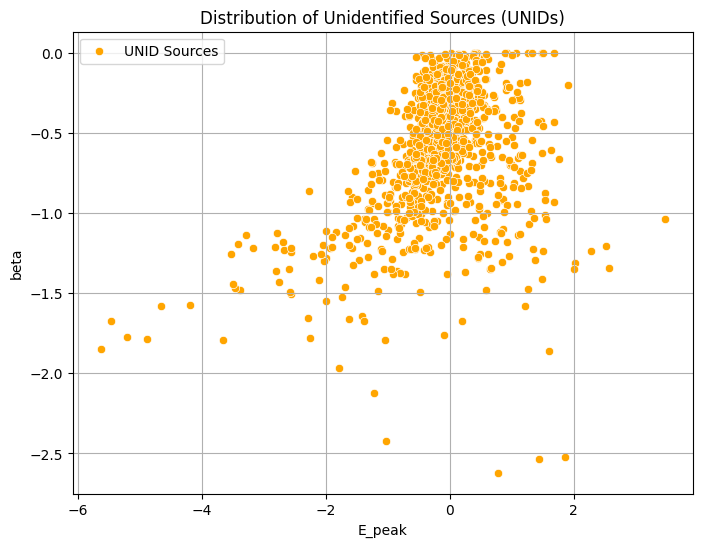

In [1126]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_unids_log, x="E_peak", y="beta", color="orange", label="UNID Sources")
plt.title("Distribution of Unidentified Sources (UNIDs)")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.legend()
plt.show()

Visualize ASTRO + UNIDs

In [1127]:
# Extraer y escalar
X_unids_log = df_unids_log[["beta", "E_peak"]].values
X_unids_scaled = scaler.transform(X_unids_log)

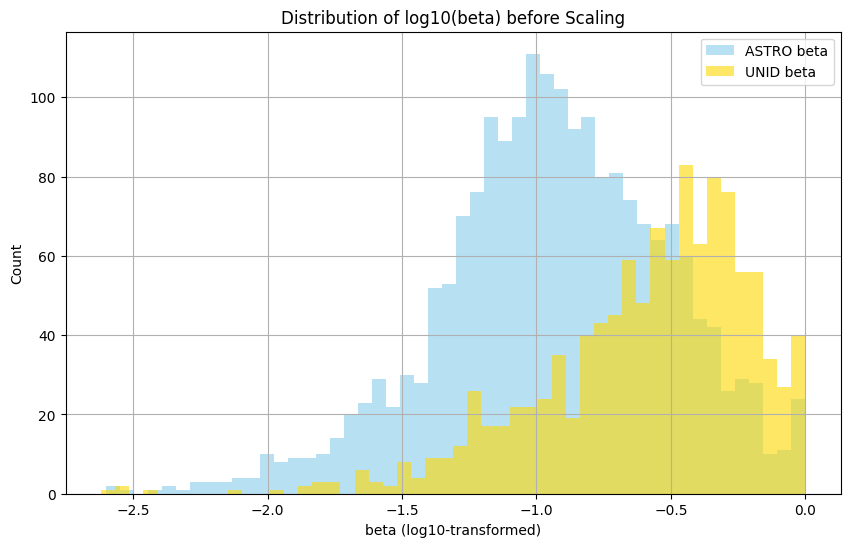

In [1128]:
plt.figure(figsize=(10, 6))
plt.hist(X_train[:, 0], bins=50, alpha=0.6, label="ASTRO beta", color="skyblue")
plt.hist(X_unids_log[:, 0], bins=50, alpha=0.6, label="UNID beta", color="gold")
plt.xlabel("beta (log10-transformed)")
plt.ylabel("Count")
plt.title("Distribution of log10(beta) before Scaling")
plt.legend()
plt.grid(True)
plt.show()

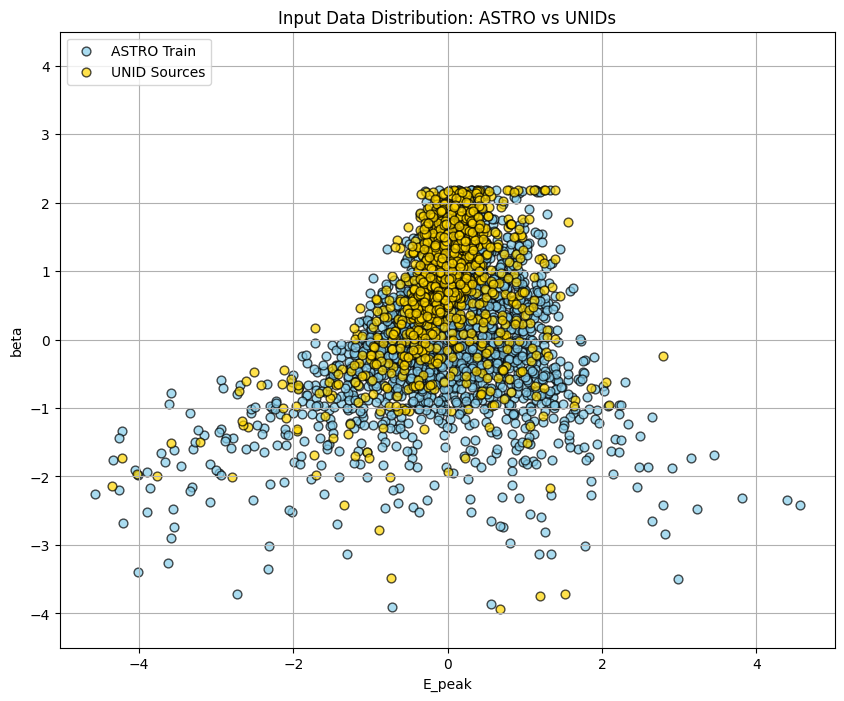

In [1129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.ylim(-4.5, 4.5)

# Plot ASTRO training data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', label='ASTRO Train', alpha=0.7, s=40)

# Plot UNID data (can be log10-transformed if you're using that version)
plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='gold', edgecolors='k', label='UNID Sources', alpha=0.7, s=40)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Input Data Distribution: ASTRO vs UNIDs")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# 🎯 Predict on UNID Data

In [1130]:
y_pred_unids = clf.predict(X_unids_scaled)
n_predicted_inliers = (y_pred_unids == 1).sum()
n_predicted_outliers = (y_pred_unids == -1).sum()
pct_outliers = 100 * n_predicted_outliers / len(X_unids_scaled)

print(f"Predicted as inliers: {n_predicted_inliers}")
print(f"Predicted as outliers (novel): {n_predicted_outliers} ({pct_outliers:.2f}%)")

Predicted as inliers: 1112
Predicted as outliers (novel): 13 (1.16%)


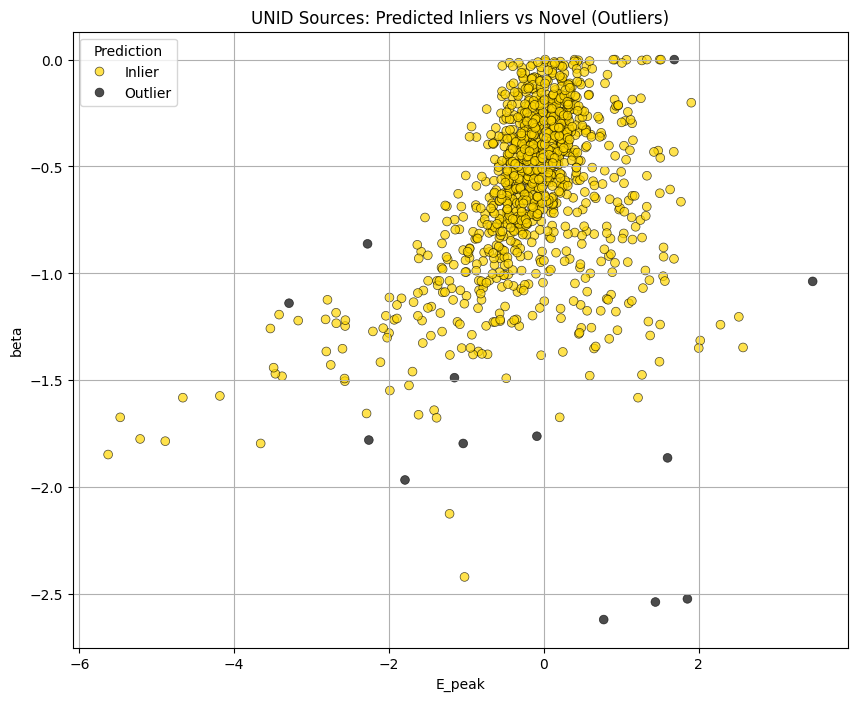

In [1131]:
plt.figure(figsize=(10, 8))

labels = np.where(y_pred_unids == -1, "Outlier", "Inlier")

sns.scatterplot(
    x=X_unids_log[:, 1],  # E_peak
    y=X_unids_log[:, 0],  # beta
    hue=labels,
    palette={"Outlier": "black", "Inlier": "gold"},
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("UNID Sources: Predicted Inliers vs Novel (Outliers)")
plt.grid(True)
plt.legend(title="Prediction", loc='upper left')
plt.show()

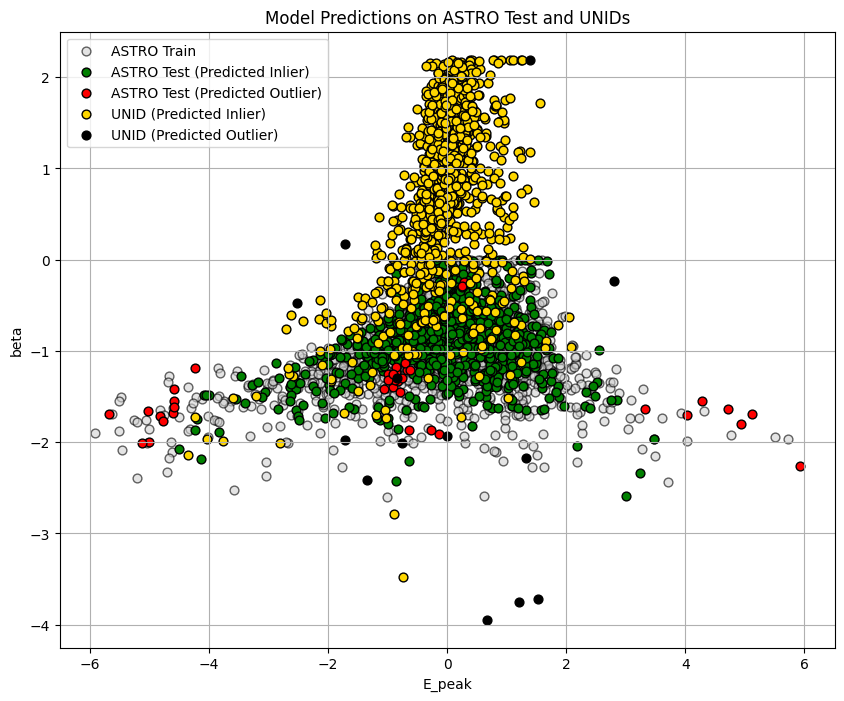

In [1132]:
import matplotlib.pyplot as plt

# Predict for test and outlier data
y_pred_test = clf.predict(X_test)          # ASTRO test data
y_pred_unids = clf.predict(X_unids_scaled)     # UNIDs

plt.figure(figsize=(10, 8))

# ASTRO Training Data (assumed all inliers, so neutral color)
plt.scatter(X_train[:, 1], X_train[:, 0], c='lightgray', edgecolors='k', label='ASTRO Train', alpha=0.6, s=40)

# ASTRO Test Data - green = predicted inlier, red = predicted outlier
plt.scatter(X_test[y_pred_test == 1][:, 1], X_test[y_pred_test == 1][:, 0],
            c='green', edgecolors='k', label='ASTRO Test (Predicted Inlier)', s=40)
plt.scatter(X_test[y_pred_test == -1][:, 1], X_test[y_pred_test == -1][:, 0],
            c='red', edgecolors='k', label='ASTRO Test (Predicted Outlier)', s=40)

# UNID Data - green = predicted inlier, red = predicted novel
plt.scatter(X_unids_scaled[y_pred_unids == 1][:, 1], X_unids_scaled[y_pred_unids == 1][:, 0],
            c='gold', edgecolors='k', label='UNID (Predicted Inlier)', s=40)
plt.scatter(X_unids_scaled[y_pred_unids == -1][:, 1], X_unids_scaled[y_pred_unids == -1][:, 0],
            c='black', edgecolors='k', label='UNID (Predicted Outlier)', s=40)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Model Predictions on ASTRO Test and UNIDs")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

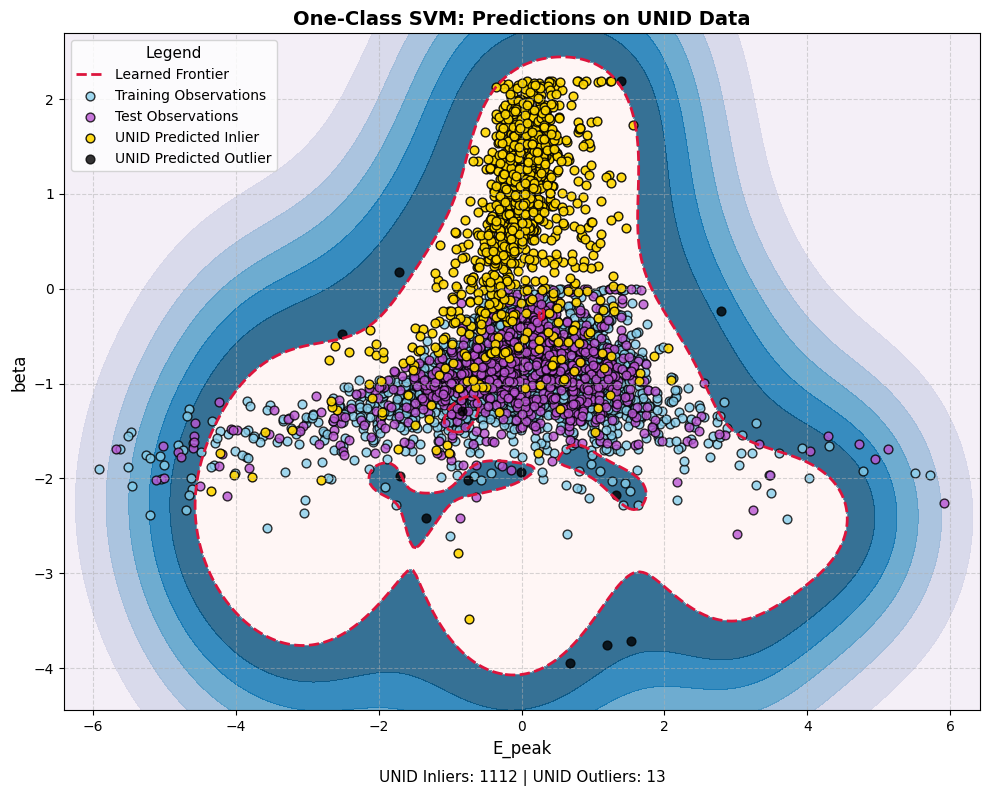

In [1133]:
import matplotlib.lines as mlines

# Meshgrid for plotting
x_min = min(X_train[:, 1].min(), X_test[:, 1].min(), X_unids_scaled[:, 1].min()) - 0.5
x_max = max(X_train[:, 1].max(), X_test[:, 1].max(), X_unids_scaled[:, 1].max()) + 0.5
y_min = min(X_train[:, 0].min(), X_test[:, 0].min(), X_unids_scaled[:, 0].min()) - 0.5
y_max = max(X_train[:, 0].max(), X_test[:, 0].max(), X_unids_scaled[:, 0].max()) + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[yy.ravel(), xx.ravel()]
Z = clf.decision_function(grid).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 8))

# Contours: decision function + learned frontier
ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap="PuBu", alpha=0.8)
ax.contour(xx, yy, Z, levels=[0], colors="crimson", linewidths=2, linestyles="--")
ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors="mistyrose", alpha=0.3)

# Base data
s = 40
b1 = ax.scatter(X_train[:, 1], X_train[:, 0], c="skyblue", edgecolors="k", s=s, label="Train", alpha=0.8)
b2 = ax.scatter(X_test[:, 1], X_test[:, 0], c="mediumorchid", edgecolors="k", s=s, label="Test", alpha=0.8)

# UNID predictions
y_pred_unids = clf.predict(X_unids_scaled)
inliers = X_unids_scaled[y_pred_unids == 1]
outliers = X_unids_scaled[y_pred_unids == -1]

c1 = ax.scatter(inliers[:, 1], inliers[:, 0], c="gold", edgecolors="k", s=s, label="UNID Inlier", alpha=0.9)
c2 = ax.scatter(outliers[:, 1], outliers[:, 0], c="black", edgecolors="k", s=s, label="UNID Outlier", alpha=0.8)

# Error count
n_inlier = len(inliers)
n_outlier = len(outliers)

# Title & annotations
ax.set_title("One-Class SVM: Predictions on UNID Data", fontsize=14, weight="bold")
ax.set_xlabel("E_peak", fontsize=12)
ax.set_ylabel("beta", fontsize=12)
ax.text(
    0.5, -0.1,
    f"UNID Inliers: {n_inlier} | UNID Outliers: {n_outlier}",
    fontsize=11, ha='center', va='center', transform=ax.transAxes
)

# Custom legend
custom_lines = [
    mlines.Line2D([], [], color="crimson", linestyle="--", linewidth=2, label="Learned Frontier"),
    b1, b2, c1, c2
]
ax.legend(
    handles=custom_lines,
    labels=[
        "Learned Frontier",
        "Training Observations",
        "Test Observations",
        "UNID Predicted Inlier",
        "UNID Predicted Outlier"
    ],
    loc="upper left",
    title="Legend",
    frameon=True,
    fontsize=10,
    title_fontsize=11
)

ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# 🌌 DARK MATTER Simulated Data

In [1134]:
# 1. Cargar y renombrar columna de clase
dm_data_path = "../data/processed/XY_bal_log_Rel/DM/XY_bal_log_Rel_DM.txt"
df_dm = pd.read_csv(dm_data_path, sep='\s+')
df_dm = df_dm.rename(columns={"0,1=astro,DM": "class"})  # 1.0 = DM, 0.0 = ASTRO

In [1135]:
df_dm.head()

,E_peak,beta,sigma,beta_Rel,class
0,2.518909,-0.313990,0.987488,0.528569,1.0
1,1.922881,-0.659556,1.345178,0.395713,1.0
2,2.463445,-0.534617,0.792322,0.288124,1.0
3,2.571126,-1.246647,0.694254,0.447771,1.0
4,1.386499,-0.951947,1.098990,-0.412871,1.0


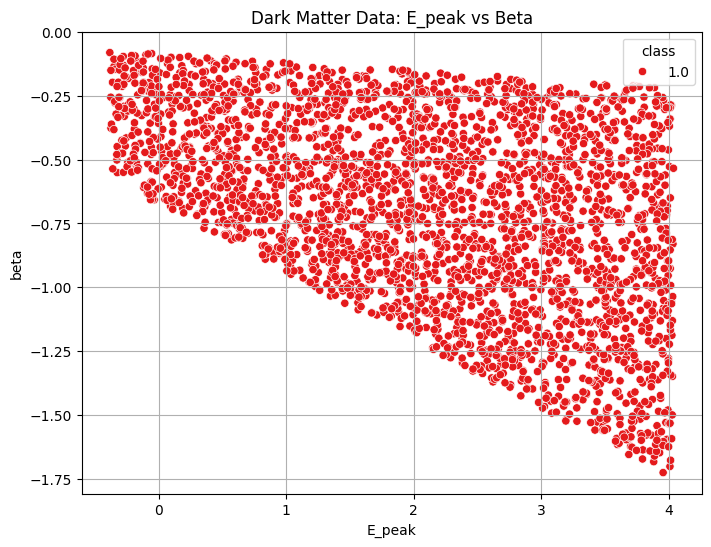

In [1136]:
# 2. Visualización
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_dm, x="E_peak", y="beta", hue="class", palette="Set1")
plt.title("Dark Matter Data: E_peak vs Beta")
plt.grid(True)
plt.show()

In [1137]:
# 3. Extraer y escalar para predicción
X_dm = df_dm[["beta", "E_peak"]].values
X_dm_scaled = scaler.transform(X_dm)  # Uso el mismo scaler del modelo

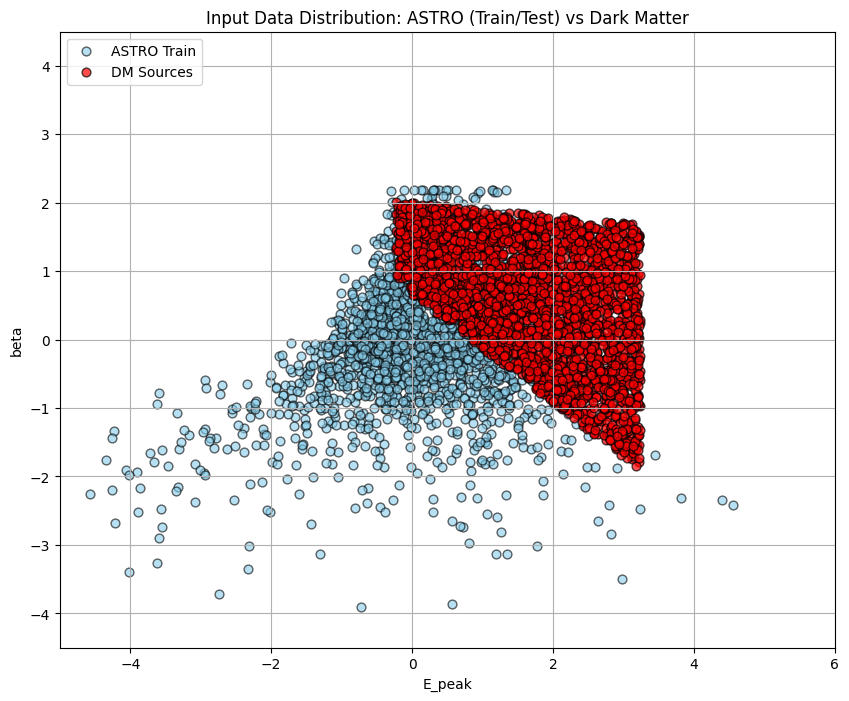

In [1138]:
plt.figure(figsize=(10, 8))

# Plot ASTRO training and test data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], 
            c='skyblue', edgecolors='k', label='ASTRO Train', alpha=0.6, s=40)

# Plot DM data
plt.scatter(X_dm_scaled[:, 1], X_dm_scaled[:, 0], 
            c='red', edgecolors='k', label='DM Sources', alpha=0.7, s=40)

# Labels and formatting
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Input Data Distribution: ASTRO (Train/Test) vs Dark Matter")
plt.grid(True)
plt.legend(loc='upper left')
plt.xlim(-5, 6)
plt.ylim(-4.5, 4.5)

# Save figure
# plt.savefig("../figures/astro_vs_dm_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

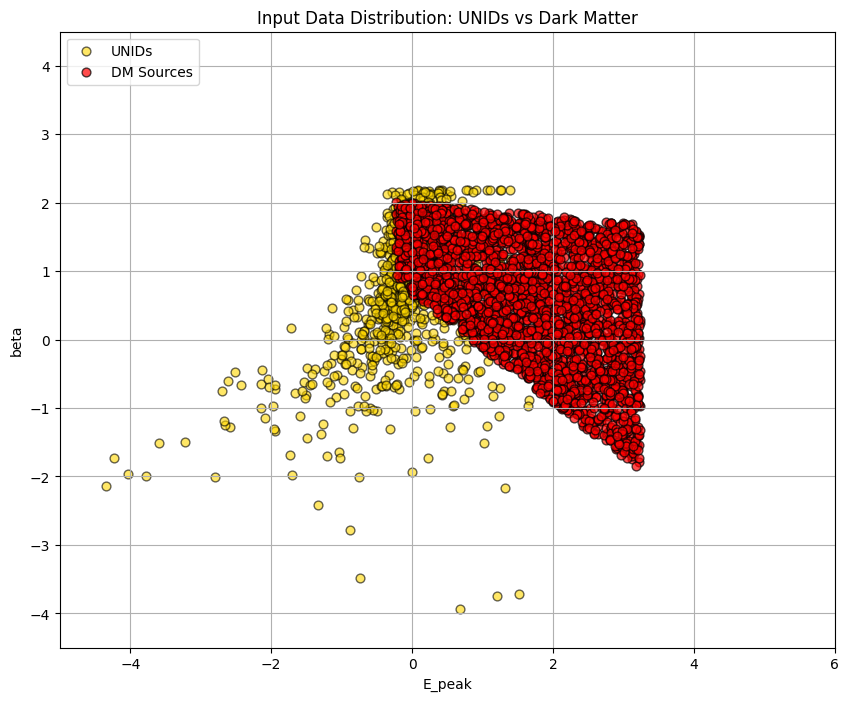

In [1139]:
plt.figure(figsize=(10, 8))

# Plot UNID data
plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], 
            c='gold', edgecolors='k', label='UNIDs', alpha=0.6, s=40)

# Plot DM data
plt.scatter(X_dm_scaled[:, 1], X_dm_scaled[:, 0], 
            c='red', edgecolors='k', label='DM Sources', alpha=0.7, s=40)

# Labels and formatting
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Input Data Distribution: UNIDs vs Dark Matter")
plt.grid(True)
plt.legend(loc='upper left')
plt.xlim(-5, 6)
plt.ylim(-4.5, 4.5)

# Save figure
# plt.savefig("../figures/astro_vs_dm_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

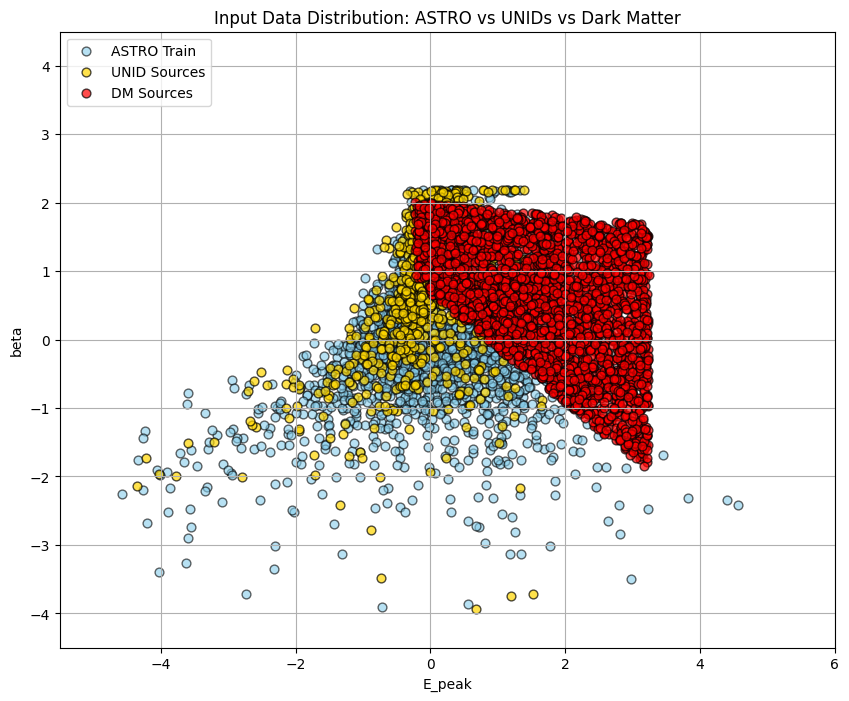

In [1140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# ASTRO data (Train + Test)
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], 
            c='skyblue', edgecolors='k', label='ASTRO Train', alpha=0.6, s=40)

# UNIDs data
plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], 
            c='gold', edgecolors='k', label='UNID Sources', alpha=0.7, s=40)

# Dark Matter data
plt.scatter(X_dm_scaled[:, 1], X_dm_scaled[:, 0], 
            c='red', edgecolors='k', label='DM Sources', alpha=0.7, s=40)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Input Data Distribution: ASTRO vs UNIDs vs Dark Matter")
plt.grid(True)
plt.legend(loc='upper left')
plt.xlim(-5.5, 6)
plt.ylim(-4.5, 4.5)

# Optional: Save
# plt.savefig("../figures/astro_unids_dm_comparison.png", dpi=300, bbox_inches="tight")

plt.show()

## 🎯 Predict on DM Data

In [1141]:
y_pred_dm = clf.predict(X_dm_scaled)

n_predicted_dm_inliers = (y_pred_dm == 1).sum()
n_predicted_dm_outliers = (y_pred_dm == -1).sum()
pct_dm_outliers = 100 * n_predicted_dm_outliers / len(y_pred_dm)

print(f"Predicted DM as inliers: {n_predicted_dm_inliers}")
print(f"Predicted DM as outliers: {n_predicted_dm_outliers} ({pct_dm_outliers:.2f}%)")

Predicted DM as inliers: 1491
Predicted DM as outliers: 1340 (47.33%)


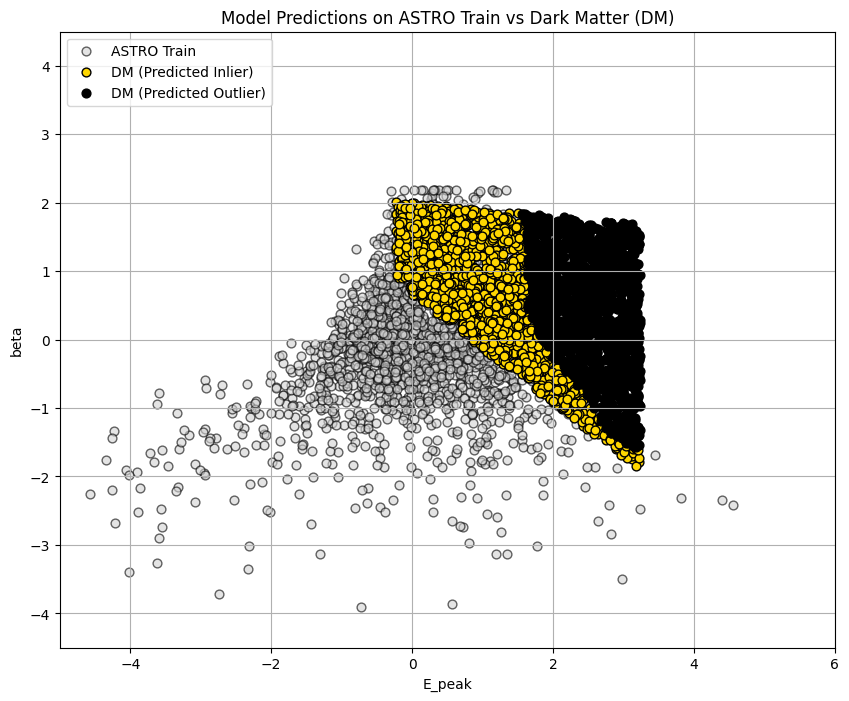

In [1142]:
import matplotlib.pyplot as plt

# Predict on DM
y_pred_dm = clf.predict(X_dm_scaled)

plt.figure(figsize=(10, 8))

# ASTRO Train (all assumed inliers)
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], 
            c='lightgray', edgecolors='k', label='ASTRO Train', alpha=0.6, s=40)

# DM Predictions
plt.scatter(X_dm_scaled[y_pred_dm == 1][:, 1], X_dm_scaled[y_pred_dm == 1][:, 0],
            c='gold', edgecolors='k', label='DM (Predicted Inlier)', s=40)
plt.scatter(X_dm_scaled[y_pred_dm == -1][:, 1], X_dm_scaled[y_pred_dm == -1][:, 0],
            c='black', edgecolors='k', label='DM (Predicted Outlier)', s=40)

# Labels and formatting
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Model Predictions on ASTRO Train vs Dark Matter (DM)")
plt.legend(loc="upper left")
plt.grid(True)
plt.xlim(-5, 6)
plt.ylim(-4.5, 4.5)
plt.show()


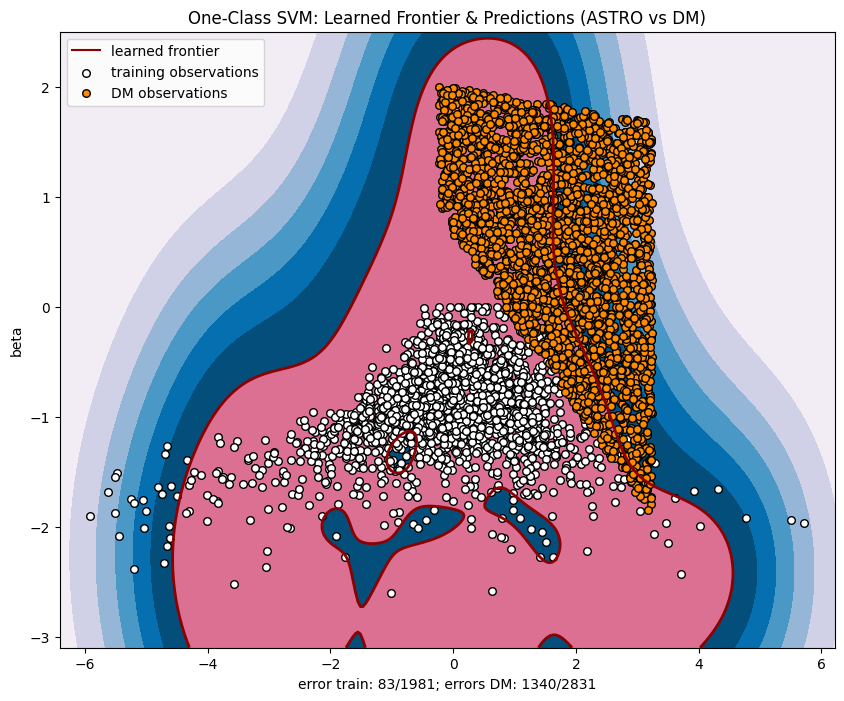

In [1143]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

# Decision function grid limits
x_min = min(X_train[:, 1].min(), X_dm_scaled[:, 1].min()) - 0.5
x_max = max(X_train[:, 1].max(), X_dm_scaled[:, 1].max()) + 0.5
y_min = min(X_train[:, 0].min(), X_dm_scaled[:, 0].min()) - 0.5
y_max = max(X_train[:, 0].max(), X_dm_scaled[:, 0].max()) + 0.5

# Grid and decision function
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[yy.ravel(), xx.ravel()]  # (beta, E_peak)
Z = clf.decision_function(grid).reshape(xx.shape)

# Predict for display
y_pred_train = clf.predict(X_train)
y_pred_dm = clf.predict(X_dm_scaled)
n_error_train = (y_pred_train == -1).sum()
n_error_dm = (y_pred_dm == -1).sum()

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Decision frontier and heatmap
ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap="PuBu")
ax.contour(xx, yy, Z, levels=[0], colors="darkred", linewidths=2)
ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

# Data points
s = 30
b1 = ax.scatter(X_train[:, 1], X_train[:, 0], c="white", s=s, edgecolors="k")           # ASTRO Train
c  = ax.scatter(X_dm_scaled[:, 1], X_dm_scaled[:, 0], c="darkorange", s=s, edgecolors="k")  # DM

# Labels and legend
ax.set(
    title="One-Class SVM: Learned Frontier & Predictions (ASTRO vs DM)",
    xlim=(xx.min(), xx.max()),
    ylim=(yy.min(), yy.max()),
    xlabel=(
        f"error train: {n_error_train}/{len(X_train)}; "
        f"errors DM: {n_error_dm}/{len(X_dm_scaled)}"
    ),
    ylabel="beta"
)

_ = ax.legend(
    [
        mlines.Line2D([], [], color="darkred", label="learned frontier"),
        b1, c
    ],
    [
        "learned frontier",
        "training observations",
        "DM observations"
    ],
    loc="upper left"
)

plt.show()


# Logs with Model Parameters, Data & Performance

In [1144]:
import os
import datetime

# Path to log file
log_path = "../logs/ocsvm_results.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)

# Timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Calculate percentages
pct_error_train = 100 * n_error_train / len(X_train)
pct_error_test = 100 * n_error_test / len(X_test)
pct_outliers_unid = 100 * n_predicted_outliers / len(X_unids_scaled)
pct_outliers_dm = 100 * n_predicted_dm_outliers / len(X_dm_scaled)

# Build log
log_lines = [
    f"========== One-Class SVM Log ({timestamp}) ==========\n",
    f"Model parameters:",
    f"    Kernel      : {clf.kernel}",
    f"    Nu          : {clf.nu}",
    f"    Gamma       : {clf.gamma}",
    "",
    f"Training data:",
    f"    Source      : ASTRO (normalized/log10)",
    f"    Samples     : {len(X_train)}",
    f"    Train errors: {n_error_train}/{len(X_train)} ({pct_error_train:.2f}%)",
    "",
    f"Testing data (ASTRO):",
    f"    Samples     : {len(X_test)}",
    f"    Test errors : {n_error_test}/{len(X_test)} ({pct_error_test:.2f}%)",
    "",
    f"UNID Outlier Detection:",
    f"    Samples     : {len(X_unids_scaled)}",
    f"    Predicted Inliers (missed outliers): {n_predicted_inliers}/{len(X_unids_scaled)}",
    f"    Predicted Outliers                 : {n_predicted_outliers}/{len(X_unids_scaled)} ({pct_outliers_unid:.2f}%)",
    "",
    f"Dark Matter (DM) Outlier Detection:",
    f"    Samples     : {len(X_dm_scaled)}",
    f"    Predicted Inliers (missed outliers): {n_predicted_dm_inliers}/{len(X_dm_scaled)}",
    f"    Predicted Outliers                 : {n_predicted_dm_outliers}/{len(X_dm_scaled)} ({pct_outliers_dm:.2f}%)",
    "",
    "======================================================\n"
]

# Append to log file
with open(log_path, "a") as f:
    f.write("\n".join(log_lines))
